# Minimum Time to Climb Problem

For a solution to the minimum time to climb problem using a Python script instead of a notebook, see the corresponding [Python script documentation](../scripts/minimum_time_to_climb.rst).

This notebook reproduces one of the main results of the seminal paper by Bryson *et al.* <cite data-footcite="Bryson:1969">(1969)</cite>, namely, to find the minimum time to climb to a given altitude by a supersonic interceptor aircraft. The equations of motion and boundary conditions are straightforward; the main difficulty in this problem is to represent the aerodynamics, which are given in tabular form. 

Betts <cite data-footcite="Betts:2010">(2010)</cite> discusses in some detail the difficulty in treating tabular data in the context of this problem. There are two problems to address: First, the thrust is a function of two variables, Mach number and altitude, and the table representing the function is coarse and incomplete. As a result, a conventional two-dimensional interpolation cannot be used. Second, the nondimensional aerodynamic coefficients are given in tabular form as functions of Mach number, for only nine Mach numbers. A naive spline fit to the data gives unsatisfactory results, and care must be taken to ensure that the fit to the data is realistic. So while the problem is conceptually straightforward, the implementation requires some care.


## Problem Definition

The objective of the problem is to minimize the objective $J$, where
$$
    J = t_f
$$
is the time to climb to 65,600 ft (20,000 m). The equations of motion are given by
$$
\begin{aligned}
    \dot{h} &= v \sin \gamma \\
    \dot{v} &= \frac{T \cos \alpha - D}{m} - g \sin \gamma \\
    \dot{\gamma} &=\frac{T \sin \alpha+L}{m v} - \frac{g \cos \gamma}{v} \\
    \dot{m} &= -\frac{T}{g I_\text{sp}}
\end{aligned}
$$
where the states are the aircraft altitude $h$, velocity $v$, flight path angle $\gamma$, and the aircraft mass $m$. The gravitational constant is
$$
    g = 32.174 \text{ft}/\text{s}^2
$$
and the specific impulse is
$$
    I_\text{sp} = 1{,}600 \text{ s}
$$

The single available control is the aircraft angle of attack $\alpha$, which appears explicity
in the equations of motion, but also appears implicitly through the lift $L$ and drag $D$. The lift and drag are given by
$$
\begin{aligned}
    L &=\frac{1}{2} C_{L} S \rho v^{2} \\
    D &=\frac{1}{2} C_{D} S \rho v^{2}
\end{aligned}
$$
where $\rho$ is the density of the atmosphere, which depends on the aircraft altitude, and $S=530\text{ ft}^2$ is the wing area. The coefficients of lift and drag are given by
$$
\begin{aligned}
    C_{L} &=C_{L \alpha} \alpha \\
    C_{D} &=C_{D 0}+\eta C_{L \alpha} \alpha^{2}
\end{aligned}
$$
where the lift curve slope $C_{L \alpha}$, drag coefficient at zero angle of attack $C_{D0}$, and the induced drag factor $\eta$ are all functions of Mach number $M$ and are expressed in tabular form in Table&nbsp;1.

The available thrust is a function of Mach number and altitude, and the data are given in Table&nbsp;2.

Note that the data in the paper by Bryson *et al.* is missing data points for high altitude and low Mach number (for which no data is available because it is below the stall speed of the aircraft), and for low altitude and high Mach number (for which data is also not available, most likely because these speeds are beyond the never exceed speeds for the aircraft).

Finally, the initial boundary conditions are
$$
\begin{aligned}
    h(0) &= 0 \text{ ft} \\
    v(0) &= 424.260 \text{ ft/s} = \text{Mach 0.38} \\
    \gamma(0) &= 0 \text{ rad} \\
    m(0) &= 42{,}000 \text{ lbm} 
\end{aligned}
$$
and the terminal boundary conditions are
$$
\begin{aligned}
    h(t_f) &= 65{,}600 \text{ ft} = 20{,}000 \text{ m}\\
    v(t_f) &= 968.148 \text{ ft/s} = \text{Mach 1.0} \\
    \gamma(t_f) &= 0 \text{ rad} 
\end{aligned}
$$

## Interpolation of Aerodynamic Data

### Density and Speed of Sound

The equations of motion depend on the density of air, $\rho$, and on the speed of sound, $c$, which is needed to compute the Mach number. These quantities are determined from the [1976 U.S. Standard Atmosphere](http://www.pdas.com/atmosTable1US.html), using a cubic spline interpolation of the tabular data. The resulting interpolation functions are ``get_rho`` and ``get_c``. 

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline

# make splines of atmospheric data, using the U.S. 1976 Standard Atmosphere in US
# customary units. Data from: http://www.pdas.com/atmosTable1US.html

# fmt: off

# density rho (slug/ft^3) and speed of sound c (ft/s) as a function of altitude h (ft)
atmosphere_data = np.array(
    #    h       rho       c
    # ------  --------  ------
    [[     0, 2.377E-3, 1116.5],
     [ 5_000, 2.048E-3, 1097.1],
     [10_000, 1.756E-3, 1077.4],
     [15_000, 1.496E-3, 1057.4],
     [20_000, 1.267E-3, 1036.9],
     [25_000, 1.066E-3, 1016.1],
     [30_000, 8.907E-4,  994.8],
     [35_000, 7.382E-4,  973.1],
     [40_000, 5.873E-4,  968.1],
     [45_000, 4.623E-4,  968.1],
     [50_000, 3.639E-4,  968.1],
     [55_000, 2.865E-4,  968.1],
     [60_000, 2.256E-4,  968.1],
     [65_000, 1.777E-4,  968.1],
     [70_000, 1.392E-4,  970.9],
     [75_000, 1.091E-4,  974.3],
     [80_000, 8.571E-5,  977.6],
     [85_000, 6.743E-5,  981.0],
     [90_000, 5.315E-5,  984.3]],
)  
# fmt: on

get_rho = CubicSpline(atmosphere_data[:, 0], atmosphere_data[:, 1])
get_c = CubicSpline(atmosphere_data[:, 0], atmosphere_data[:, 2])

### Available Thrust

As discussed earlier, the tabular data for available thrust (Table&nbsp;2) is missing data outside the flight envelope. As a result, a simple two-dimensional spline is not feasible. Instead, we use a radial basis function (RBF) interpolation, which is appropriate for unstructured data. We first scale the independent axes to a range of $[0,1]$, and then pass the data to the SciPy function ``RBFInterpolator`` to generate the interpolation function ``thrust_function``.

In [2]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi
from scipy.interpolate import RBFInterpolator
from yapss import Problem

# Mach number and altitude arrays
mach_data = np.array((0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8))
# Data is in thousands of feet
h_data = np.array((0, 5, 10, 15, 20, 25, 30, 40, 50, 70), dtype=float)

# normalize so that each array has range [0,1]
h_data /= 70.0
mach_data /= 1.8

# Thrust data. Note that there are zero entries where the data is unknown or
# undefined. Thrust is in thousands of lbf.
# fmt: off
thrust_data = np.array(
    [[24.2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
     [28.0, 24.6, 21.1, 18.1, 15.2, 12.8, 10.7,    0,    0,    0],
     [28.3, 25.2, 21.9, 18.7, 15.9, 13.4, 11.2,  7.3,  4.4,    0],
     [30.8, 27.2, 23.8, 20.5, 17.3, 14.7, 12.3,  8.1,  4.9,    0],
     [34.5, 30.3, 26.6, 23.2, 19.8, 16.8, 14.1,  9.4,  5.6,  1.1],
     [37.9, 34.3, 30.4, 26.8, 23.3, 19.8, 16.8, 11.2,  6.8,  1.4],
     [36.1, 38.0, 34.9, 31.3, 27.3, 23.6, 20.1, 13.4,  8.3,  1.7],
     [   0, 36.6, 38.5, 36.1, 31.6, 28.1, 24.2, 16.2, 10.0,  2.2],
     [   0,    0,    0, 38.7, 35.7, 32.0, 28.1, 19.3, 11.9,  2.9],
     [   0,    0,    0,    0,    0, 34.6, 31.1, 21.7, 13.3,  3.1]],
)  # fmt: on

# convert to lbf
thrust_data *= 1000

# Find non-empty entries in thrust table, and form argument and value arrays for the
# radial basis function interpolator
thrust_table = []
mh = []
for j, mj in enumerate(mach_data):
    for k, hk in enumerate(h_data):
        thrust_data_point = thrust_data[j][k]
        if thrust_data_point != 0:
            thrust_table.append(thrust_data_point)
            mh.append([mj, hk])

thrust_rbf_interpolator = RBFInterpolator(
    mh,
    thrust_table,
    smoothing=0,
    kernel="cubic",
)


def thrust_function(mach, h):
    """Determine the thrust available at the given mach numbers and altitudes."""
    shape = mach.shape
    length = 1
    for i in shape:
        length *= i
    mach = mach.reshape([length])
    h = h.reshape([length])
    thrust = thrust_rbf_interpolator(np.stack([mach / 1.8, h / 70000], -1))
    thrust = thrust.reshape(shape)
    return thrust

To determine how well the interpolation works, a 3D wireframe mesh of the calculated thrust versus Mach number and altitude is plotted:

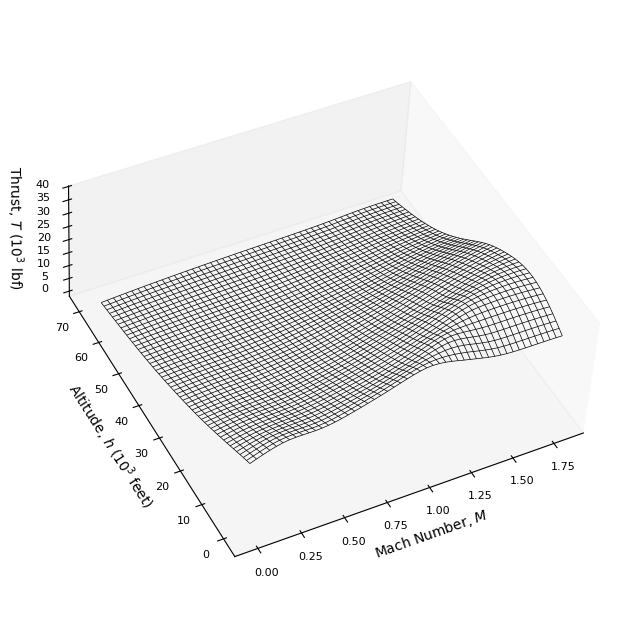

In [3]:
# Form a regular mesh of Mach numbers and altitudes
mach = np.linspace(0, 1.8, num=50)
h = np.linspace(0, 70000, num=50)
mach, h = np.meshgrid(mach, h)
thrust = thrust_function(mach, h)

# Plot the wireframe mesh
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(mach, h / 1000, thrust / 1000, rstride=1, cstride=1, linewidths=0.5, color="k")
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.tick_params(axis="z", labelsize=8)
ax.set_xlabel("Mach Number, $M$", fontsize=10)
ax.set_ylabel("Altitude, $h$ ($10^3$ feet)", fontsize=10)
ax.set_zlabel("Thrust, $T$ ($10^3$ lbf)", fontsize=10)
ax.grid(False)
ax.set_box_aspect([1, 1, 0.4], zoom=0.9)
ax.view_init(elev=45, azim=240, roll=-4)

Looking at the plot above, we see that there is a small amount of rippling in the contours for Mach numbers $M \ge 1.25$ and altitudes below 25,000 ft. As it turns out, the optimal trajectory does not pass through this region, and so this interpolation should suffice.

### Lift and Drag Coefficients

The lift and drag coefficients are determined by the data in Table 1. The data is fairly sparse, and a simple cubic spline interpolation gives unsatisfactory results. For example, here is the cubic spline for the zero-lift drag coefficient ${C_D}_0$:

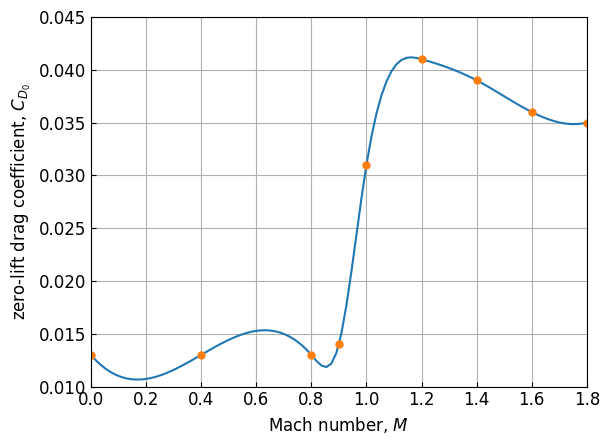

In [4]:
mach_cd0 = [0, 0.4, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8]
cd0 = [0.013, 0.013, 0.013, 0.014, 0.031, 0.041, 0.039, 0.036, 0.035]
get_cd0 = CubicSpline(mach_cd0, cd0)

mach = np.linspace(0, 1.8, 100)
plt.plot(mach, get_cd0(mach))
plt.plot(mach_cd0, cd0, ".", markersize=10)
plt.ylabel(r"zero-lift drag coefficient, $C_{D_{0}}$")
plt.xlabel(r"Mach number, $M$")
plt.xlim([0.0, 1.8])
plt.ylim([0.01, 0.045])
plt.grid()

It seems clear that the drag coefficient is supposed to be constant (or nearly so) in the subsonic regime $M \le 0.8$. Because of the sparse data, some artistic license is necessary to interpret the data. To get a reasonable result, we add additional knots near $M=0.80$ and at $M=0.86$ to constrain the curve of ${C_D}_0$ from falling below the subsonic value of 0.013. 

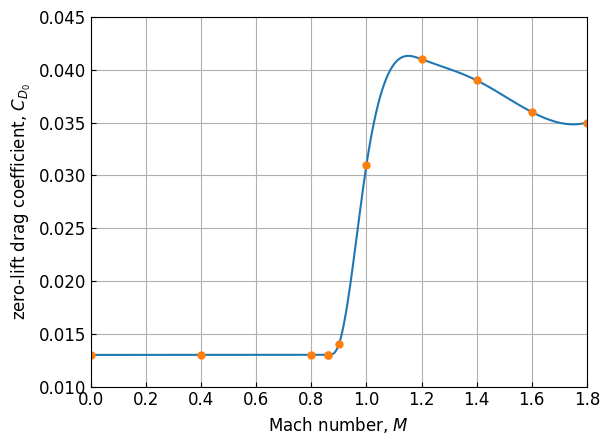

In [5]:
# define the spline for {C_D}_0
eps = 1e-5
mach_cd0 = [0, 0.4, 0.8, 0.86 - eps, 0.86, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8]
cd0 = [0.013, 0.013, 0.013, 0.013, 0.013, 0.014, 0.031, 0.041, 0.039, 0.036, 0.035]
get_cd0 = CubicSpline(mach_cd0, cd0)

mach = np.linspace(0, 1.8, 1000)
plt.plot(mach, get_cd0(mach))
plt.plot(mach_cd0, cd0, ".", markersize=10)
plt.ylabel(r"zero-lift drag coefficient, $C_{D_{0}}$")
plt.xlabel(r"Mach number, $M$")
plt.xlim([0.0, 1.8])
plt.ylim([0.01, 0.045])
plt.grid()

We do the same for the  lift curve ${C_L}_\alpha$ and the induced drag parameter $\eta$.

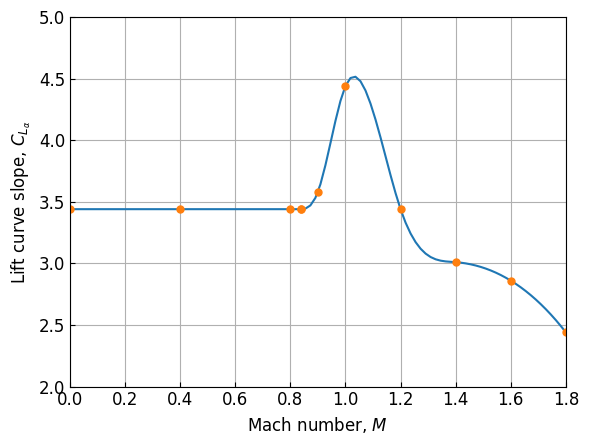

In [6]:
# lift curve slope (CLalpha)
mach_cla = [0, 0.4, 0.8, 0.84 - eps, 0.84, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8]
cla = [3.44, 3.44, 3.44, 3.44, 3.44, 3.58, 4.44, 3.44, 3.01, 2.86, 2.44]
get_cla = CubicSpline(mach_cla, cla)

mach = np.linspace(0, 1.8, 100)
plt.figure()
plt.plot(mach, get_cla(mach))
plt.plot(mach_cla, cla, ".", markersize=10)
plt.ylabel(r"Lift curve slope, $C_{L_{\alpha}}$")
plt.xlabel(r"Mach number, $M$")
plt.xlim([0.0, 1.8])
plt.ylim([2, 5])
plt.grid()

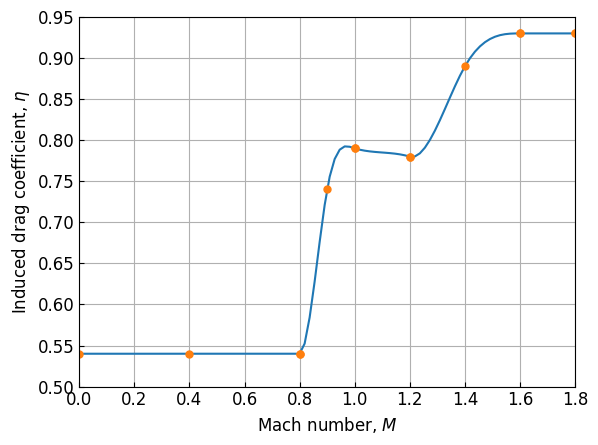

In [7]:
# eta
# fmt: off
mach_eta = [
    0, 0.4, 0.8 - eps, 0.8, 0.9, 1.0, 1.0 + eps, 1.2 - eps, 1.2, 1.4, 
    1.6, 1.6 + eps, 1.8 - eps, 1.8,
]
eta_data = [
    0.54, 0.54, 0.54, 0.54, 0.75 - 0.01, 0.79, 0.79 - eps / 10, 
    0.78 + eps / 10, 0.78, 0.89, 0.93, 0.93, 0.93, 0.93,
]
# fmt: on

get_eta = CubicSpline(mach_eta, eta_data)

mach = np.linspace(0, 1.8, 100)
plt.figure()
plt.plot(mach, get_eta(mach))
plt.plot(mach_eta, eta_data, ".", markersize=10)
plt.ylabel(r"Induced drag coefficient, $\eta$")
plt.xlabel(r"Mach number, $M$")
plt.xlim([0.0, 1.8])
plt.ylim([0.5, 0.95])
plt.grid()

## YAPSS Solution

The optimal control problem has four states: altitude ($h$), velocity ($v$), flight path angle ($\gamma$), and vehicle mass ($M$). There is a single control, the aircraft angle of attack ($\alpha$)). So the problem is instantiated as:

In [8]:
from yapss import Problem

problem = Problem(name="Bryson Minimum Time to Climb", nx=[4], nu=[1])

The objective and continuous callback functions are straightforward translations from the problem definition:

In [9]:
from yapss.math import cos, sin

# constants
S = 530
g = 32.174
Isp = 1600


def objective(arg):
    """Minimize the total time to climb"""
    arg.objective = arg.phase[0].final_time


def continuous(arg):
    h, v, gamma, mass = arg.phase[0].state
    (alpha,) = arg.phase[0].control

    # get atmospheric data and coefficients
    rho = get_rho(h)
    c = get_c(h)
    mach = v / c
    CD0 = get_cd0(mach)
    Clalpha = get_cla(mach)
    eta = get_eta(mach)
    CD = CD0 + eta * Clalpha * alpha**2
    CL = Clalpha * alpha

    # compute the forces
    q = 0.5 * rho * v**2
    D = q * S * CD
    L = q * S * CL
    thrust = thrust_function(mach, h)

    # compute the state derivatives
    hdot = v * sin(gamma)
    vdot = (thrust * cos(alpha) - D) / mass - g * sin(gamma)
    gammadot = (thrust * sin(alpha) + L - mass * g * cos(gamma)) / (mass * v)
    mdot = -thrust / (g * Isp)

    arg.phase[0].dynamics[:] = hdot, vdot, gammadot, mdot


problem.functions.objective = objective
problem.functions.continuous = continuous

The bounds for the problem are determined by the initial and final conditions. We are set loose box bounds on the decision variables:

In [10]:
# initial and final conditions
t0 = 0
h0, v0, gamma_0, m0 = 0, 424.260, 0, 42000.0 / g
hf, vf, gamma_f = 65600, 968.148, 0

# variable ranges
tf_min, tf_max = 100, 800
h_min, h_max = 0, 69000
v_min, v_max = 1, 2000
gamma_min = -40 * pi / 180
gamma_max = 40 * pi / 180
m_min, m_max = 10, 45000 / g
alpha_min, alpha_max = -pi / 4, pi / 4

# set the bounds
bounds = problem.bounds.phase[0]
bounds.initial_time.lower = bounds.initial_time.upper = t0
bounds.final_time.lower = tf_min
bounds.final_time.upper = tf_max
bounds.initial_state.lower = bounds.initial_state.upper = h0, v0, gamma_0, m0
bounds.state.lower = h_min, v_min, gamma_min, m_min
bounds.state.upper = h_max, v_max, gamma_max, m_max
bounds.final_state.lower = hf, vf, gamma_f, m_min
bounds.final_state.upper = hf, vf, gamma_f, m_max
bounds.control.lower = (alpha_min,)
bounds.control.upper = (alpha_max,)

The initial guess of the state trajectory is a straight line interpolation between the initial and final conditions, except for the mass, for which the guess is a constant value. The initial guess for the final time is $t_f = 300 \text{ s}$.

In [11]:
# guess
guess = problem.guess.phase[0]
guess.time = [0, 300]
guess.state = [[h0, hf], [v0, vf], [gamma_0, gamma_f], [m0, m0]]
guess.control = [[0, 0]]

The scale factors are taken to be roughly half the range of each of the variables:

In [12]:
# scaling
problem.scale.phase[0].state = [30000.0, 1000.0, 3.0, 500.0]
problem.scale.phase[0].dynamics = problem.scale.phase[0].state
problem.scale.phase[0].control = [0.2]
problem.scale.objective = 200
problem.scale.phase[0].time = 200

Finally, we set the YAPSS and Ipopt options and solve. Note that because the aerodynamic data cannot be automatically differentiated, the differentiation must be performed numerically.

In [13]:
problem.derivatives.method = "central-difference"

# mesh
m, n = 30, 8
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].fraction = m * (1.0 / m,)

# ipopt options
problem.ipopt_options.max_iter = 1000
problem.ipopt_options.tol = 1e-10
problem.ipopt_options.acceptable_tol = 1e-8
problem.ipopt_options.print_level = 3
problem.ipopt_options.sb = "yes"

solution = problem.solve()

Total number of variables............................:     1169
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1049
                     variables with only upper bounds:        0
Total number of equality constraints.................:      960
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0




Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   1.6022943189845054e+00    3.2045886379690108e+02
Dual infeasibility......:   4.7766135378325322e-10    1.1404999261448903e-09
Constraint violation....:   6.2277649703901258e-13    7.8289303928613663e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000000000012e-11    2.0000000000000026e-09
Overall NLP error.......:   4.7766135378325322e-10    7.8289303928613663e-09


Number of objective function evaluations             = 53
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 53
Number of inequality constraint evaluations          = 53
Number of equality constraint Jacobian evaluations   = 47
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total seconds in IPOPT (w/o 

function evaluations)    =      0.130
Total seconds in NLP function evaluations            =      0.583

EXIT: Solved To Acceptable Level.


## Plots of Solution

To plot the solution, we first extract the state, control, and time histories:

In [14]:
# extract state and control histories
h, v, gamma, mass = solution.phase[0].state
alpha = solution.phase[0].control[0]

# time arrays
t = solution.phase[0].time  # interpolation points
tc = solution.phase[0].time_c  # collocation points

### Altitude vs. Velocity

The most useful plot for understanding the solution is a plot of the trajectory on altitude vs. velocity axes, on which are superimposed contours of excess power and total energy height. The excess power is 
$$
    \mathbb{P_\text{e}} = (T-D) v
$$
and the energy height is
$$
    h_\text{E} = h + \frac{v^2}{2g}
$$

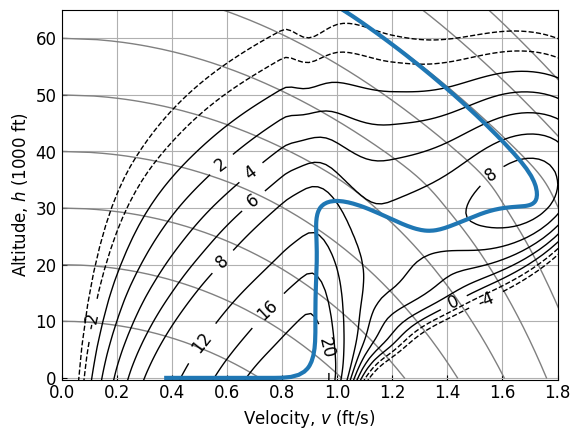

In [15]:
def get_excess_power(h, v):
    """Determine the excess power available at each altitude h and airspeed v."""
    # use rough average weight to compute excess power
    m = 40000 / g

    # calculate required thrust for level flight
    mach = v / get_c(h)
    CD0 = get_cd0(mach)
    Clalpha = get_cla(mach)
    eta = get_eta(mach)
    qs = 0.5 * get_rho(h) * v**2 * S
    CL = m * g / qs
    alpha = CL / Clalpha
    CD = CD0 + eta * Clalpha * alpha**2
    D = qs * CD
    thrust = thrust_function(mach, h)

    return (thrust - D) * v


def plot_trajectory(solution):
    h, v, gamma, mass = solution.phase[0].state
    t = solution.phase[0].time
    tc = solution.phase[0].time_c
    alpha = solution.phase[0].control[0]
    g = 32.174  # 9.80665
    for h_energy in np.linspace(10000, 100000, num=10, endpoint=True):
        h_ = np.linspace(0, h_energy, num=250, endpoint=True)
        v_ = np.sqrt(2 * g * (h_energy - h_))
        plt.plot(v_ / get_c(h_), h_ / 1000, "grey", linewidth=1)

    # excess power contours
    h_grid = np.linspace(-1000, 70000, num=100)
    v_grid = np.linspace(0.1, 2000, num=100)
    v_grid, h_grid = np.meshgrid(v_grid, h_grid)
    power = get_excess_power(h_grid, v_grid)
    mach_grid = v_grid / get_c(h_grid)
    cp = plt.contour(
        mach_grid,
        h_grid / 1000,
        power / 1e6,
        [-4, -2, 0, 2, 4, 6, 8, 12, 16, 20],
        colors="k",
        linewidths=1,
    )
    plt.clabel(cp, fmt=r"%1.0f")

    plt.plot(v / get_c(h), h / 1000, linewidth=3)
    plt.xlabel(r"Velocity, $v$ (ft/s)")
    plt.ylabel(r"Altitude, $h$ (1000 ft)")
    # plt.xlim(0, 1800)
    plt.xlim(0, 1.8)
    plt.ylim(-0.3, 65)
    plt.grid()


plot_trajectory(solution)

The units of the labels for the excess power contours are $10^6$ ft-lbf/s. The trajectory has five phases:

1. The aircraft flies at sea level, accelerating to about Mach 0.87.
2. The aircraft then climbs at nearly constant Mach number, operating at close to the speed for
   maximum excess power at each altitude, just below the large increase in drag in the transonic
   region.
4. At about 44,000 ft, the aircraft then dives to rapidly accelerate through the transonic region,
   to reach an island of large excess power.
5. In the region of large excess power, the aircraft maintains level flight until achieving the
   required energy height.
6. Finally, the aircraft performs a zoom climb at large flight path angle to reach the desired
   final altitude.

The state and control histories are plotted in the sections below.

### Altitude

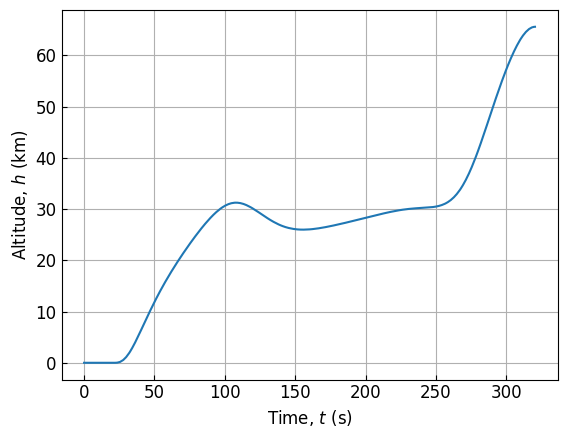

In [16]:
plt.plot(t, h / 1000)
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Altitude, $h$ (km)")
plt.grid()

### Velocity

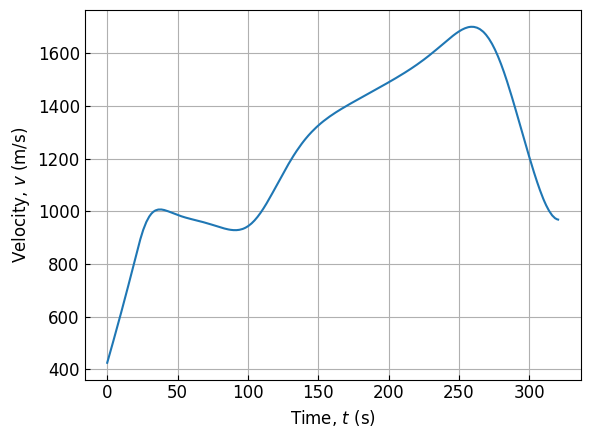

In [17]:
plt.plot(t, v)
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Velocity, $v$ (m/s)")
plt.grid()

### Flight Path Angle

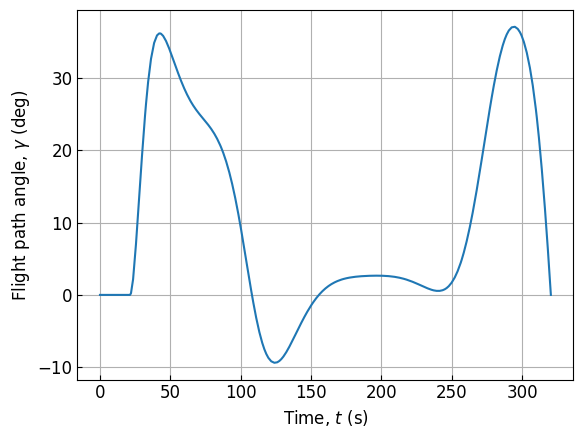

In [18]:
plt.plot(t, np.degrees(gamma))
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Flight path angle, $\gamma$ (deg)")
plt.grid()

### Vehicle Mass

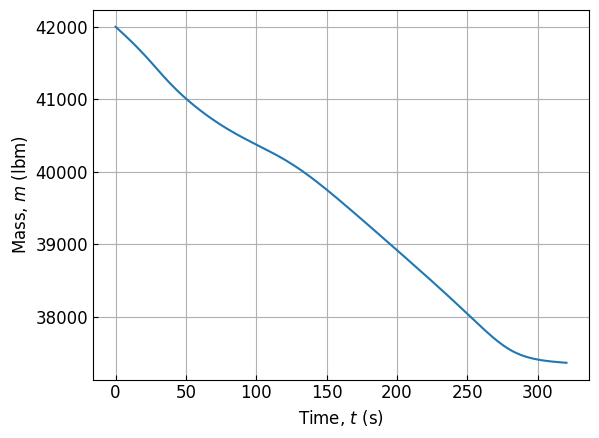

In [19]:
plt.plot(t, mass * 32.174)
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Mass, $m$ (lbm)")
plt.grid()

### Angle of Attack

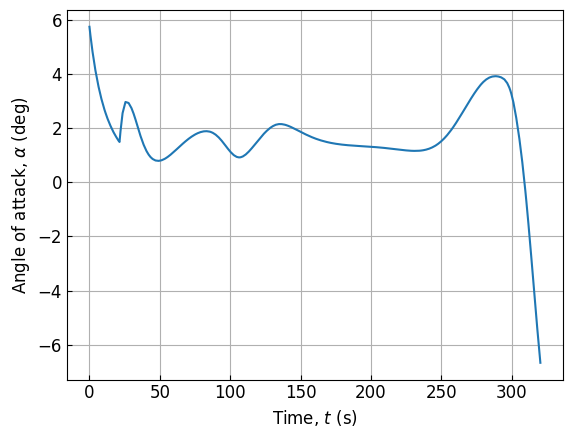

In [20]:
plt.plot(tc, alpha * 180 / np.pi)
plt.xlabel(r"Time, $t$ (s)")
plt.ylabel(r"Angle of attack, $\alpha$ (deg)")
plt.grid()

## Minimum Fuel to Climb

Finally, given the effort to get this point, it's straightforward to solve a different but related problem, namely to minimize the fuel required to climb to the same final condition. It's only necessary to change the objective. Note that we use the original solution to generate the guess for this problem, which reduces slightly the required solution time.

In [21]:
def objective(arg):
    """Minimum fuel to climb objective"""
    arg.objective = -arg.phase[0].final_state[3]


problem.functions.objective = objective

# original guess would work, but the prior solution is a much better guess
problem.guess(solution)

# reduce the printout
problem.ipopt_options.print_level = 3

# solve
solution_2 = problem.solve()

Total number of variables............................:     1169
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1049
                     variables with only upper bounds:        0
Total number of equality constraints.................:      960
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0




Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:  -5.8883546863072027e+00   -1.1776709372614405e+03
Dual infeasibility......:   2.0863381180972117e-10    6.9316149315366955e-10
Constraint violation....:   5.0113158067688350e-13    1.0135408956557512e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000000000012e-11    2.0000000000000026e-09
Overall NLP error.......:   2.0863381180972117e-10    1.0135408956557512e-08


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 39
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 32
Number of inequality constraint Jacobian evaluations = 32
Number of Lagrangian Hessian evaluations             = 31
Total seconds in IPOPT (w/o 

function evaluations)    =      0.078
Total seconds in NLP function evaluations            =      0.395

EXIT: Solved To Acceptable Level.


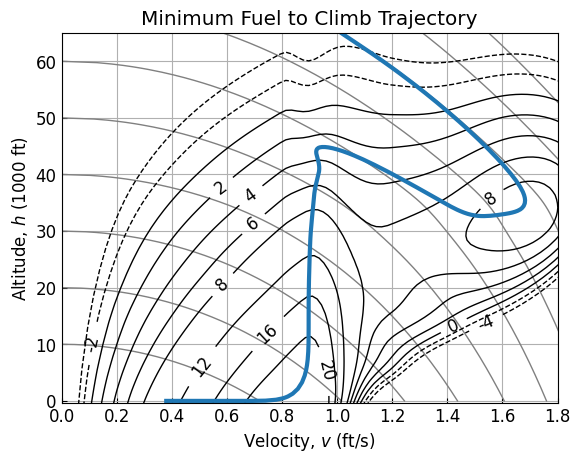

In [22]:
plot_trajectory(solution_2)
plt.title("Minimum Fuel to Climb Trajectory");

In [23]:
delta_m = solution_2.phase[0].state[3][-1] - solution.phase[0].state[3][-1]
delta_t = solution_2.phase[0].final_time - solution.phase[0].final_time

print(f"{delta_m = :.1f} lbm")
print(f"{delta_t = :.1f} s")

delta_m = 16.4 lbm
delta_t = 61.1 s


So the minimum fuel trajectory saves 16.4 pounds of fuel, but takes 61.1 s longer to reach the desired final state.

## References